# CNN and LRP on Social Physical brain

This notebook shows how saliency maps are computed for social and physical pain brain dataset. 

We will first train a model and then apply LRP methods. 

## Imports

In [1]:
%load_ext autoreload
%autoreload 2

import warnings
warnings.simplefilter('ignore')

In [2]:
%matplotlib inline  

import h5py
import imp
import numpy as np
import os


import keras
import keras.backend
import keras.models

import tensorflow as tf
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
session = tf.Session(config=config)


from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Activation
from keras.layers import Conv2D, MaxPooling2D
from keras.optimizers import Adam
from keras import regularizers
from keras import backend as K

import sys
sys.path.insert(0, '../')

import innvestigate
import innvestigate.utils as iutils
import innvestigate.utils.visualizations as ivis

from matplotlib import pyplot as plt

sys.path.insert(0, '../../')
# Use utility libraries to focus on relevant iNNvestigate routines.
eutils = imp.load_source("utils", "utils_lrp.py")


Using TensorFlow backend.


## Variable
Set the variable for making model and the analysis.

Before running, unzip 'mini_example_social_physical_masked_cross.hdf5' in data folder. 

* mini_batch_size : batch size you want to run
* data_file_name : where your data exist
* label_to_class_name : put labels in the list
* selection_index_LRP : which index do you want the LRP results with? 1 is for Social score and 0 is for Physical score and None is for the most model prediction score.

In [3]:
mini_batch_size = 128
data_file_name = 'data/mini_example_social_physical_masked_cross.hdf5'
label_to_class_name = [str(i) for i in range(2)]
selection_index_LRP = 0 # 0, 1, None

## Model
This part is for training and evaluating CNN.

In [4]:
# make CNN model with 6 layers, Flatten() is inserted between CNN and fully connected layers.
def make_custom_model_cnn_2D():
    
    model = Sequential() 
    model.add(Conv2D(8, (3,3), kernel_initializer='he_normal', padding='same', input_shape=(68,95,79)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))


    model.add(Conv2D(16, (3,3), kernel_initializer='he_normal', padding='same'))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))

    model.add(Conv2D(32, (3,3), kernel_initializer='he_normal', padding='same'))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))

    model.add(Conv2D(64, (3,3), kernel_initializer='he_normal', padding='same'))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))


    model.add(Flatten()) 
    model.add(Dense(128, kernel_initializer='he_normal'))
    model.add(Activation('relu'))
    
    model.add(Dense(2, kernel_initializer='he_normal'))
    model.add(Activation('linear'))
    
    model.add(Activation('softmax'))
    
    adam = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)

    model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])

    return model

In [5]:
# Functions for creating & training model
def train_model():

    # Option : when you have enough GPUs, it will be better to cancle the annotation of below line 
#     with tf.device('/cpu:0'):

    with h5py.File(data_file_name, "r") as data:

        for i in range(0,3):  # i is the cross number 59

            print('this is ith iter : ' , i)

            tr_data_X_name = 'cross_'+str(i+1)+ '_X'+'_train'
            tr_data_y_name = 'cross_'+str(i+1)+ '_y'+'_train'
            te_data_X_name = 'cross_'+str(i+1)+ '_X'+'_test'
            te_data_y_name = 'cross_'+str(i+1)+ '_y'+'_test'

            tr_data = {}
            tr_data['X_data'] = np.array(data[tr_data_X_name])
            tr_data['y_data'] = np.array(data[tr_data_y_name])
            
            te_data = {}
            te_data['X_data'] = np.array(data[te_data_X_name])
            te_data['y_data'] = np.array(data[te_data_y_name])
            
            tr_data['y_data'] = keras.utils.to_categorical(tr_data['y_data'], 2)
            te_data['y_data'] = keras.utils.to_categorical(te_data['y_data'], 2)
   
            training_sample_count = tr_data['X_data'].shape[0]


            # Initialize and compile the model
            model = make_custom_model_cnn_2D()
            model.compile(loss="categorical_crossentropy",
                          optimizer=Adam(),
                          metrics=["accuracy"])
            history = model.fit(tr_data['X_data'],
                                tr_data['y_data'],
                                batch_size=mini_batch_size,
                                epochs=20,
                                verbose=1)
            score = model.evaluate(te_data['X_data'], 
                                   te_data['y_data'], 
                                   verbose=0)
            return model,score


In [6]:
# Create & train model
model,score = train_model()

this is ith iter :  0
Epoch 1/20
928/928 [==============================] - 5s 6ms/step - loss: 1.1083 - acc: 0.5399
Epoch 2/20
928/928 [==============================] - 5s 5ms/step - loss: 0.6548 - acc: 0.6584
Epoch 3/20
928/928 [==============================] - 5s 6ms/step - loss: 0.5452 - acc: 0.7511
Epoch 4/20
928/928 [==============================] - 4s 4ms/step - loss: 0.4719 - acc: 0.8103
Epoch 5/20
928/928 [==============================] - 5s 5ms/step - loss: 0.3781 - acc: 0.8481
Epoch 6/20
928/928 [==============================] - 5s 5ms/step - loss: 0.3314 - acc: 0.8707
Epoch 7/20
928/928 [==============================] - 4s 5ms/step - loss: 0.3049 - acc: 0.8836
Epoch 8/20
928/928 [==============================] - 5s 5ms/step - loss: 0.2407 - acc: 0.9106
Epoch 9/20
928/928 [==============================] - 5s 5ms/step - loss: 0.1995 - acc: 0.9278
Epoch 10/20
928/928 [==============================] - 5s 5ms/step - loss: 0.1609 - acc: 0.9494
Epoch 11/20
928/928 [======

## Accuracy

In [7]:
#List for save accuracy
val_acc = [] 


with h5py.File(data_file_name, "r") as data:

    for i in range(0,1):  # i is the cross number 59

        te_data_X_name = 'cross_'+str(i+1)+ '_X'+'_test'
        te_data_y_name = 'cross_'+str(i+1)+ '_y'+'_test'

        te_data = {}
        te_data['X_data'] = np.array(data[te_data_X_name])
        te_data['y_data'] = np.array(data[te_data_y_name])
        
        te_data['y_data'] = keras.utils.to_categorical(te_data['y_data'], 2)
        

        score = model.evaluate(te_data['X_data'], te_data['y_data'], verbose=0)
        val_acc.append(score[1])
        
        print("accuracy for ", i, " th iter : ",score[1])

print("mean of validation accuracy : ",np.mean(val_acc))


accuracy for  0  th iter :  1.0
mean of validation accuracy :  1.0


## Analysis

Set up a list of analysis methods used by `innvestigate.analyzer.create_analyzer(...)`, some optional parameters, a post processing choice for visualizing the computed analysis and a title for the figure to render. 


For a full list of methods refer to the dictionary `investigate.analyzer.analyzers`

In [8]:
# Configure analysis methods and properties
if selection_index_LRP == None:
    methods = [
    ("lrp.epsilon",    {"epsilon": 1,"neuron_selection_mode":"max_activation"},    ivis.heatmap,    "LRP-Epsilon"),
    ]
else:    
    methods = [
    ("lrp.epsilon",    {"epsilon": 1, "neuron_selection_mode" : "index"},    ivis.heatmap,     "LRP-Epsilon"),
    ]

The main loop below will now instantiate the analyzer objects based on the loaded/trained model and the analyzers' parameterizations above.

In [9]:
# Create model without trailing softmax
model_wo_softmax = iutils.keras.graph.model_wo_softmax(model)

# Create analyzers.
analyzers = []
for method in methods:
    
    analyzer = innvestigate.create_analyzer(method[0],        # analysis method identifier
                                            model_wo_softmax, # model without softmax output
                                            **method[1])      # optional analysis parameters

    # Some analyzers require training.
    analyzer.fit(data, batch_size=256, verbose=1)
    analyzers.append(analyzer)
    

Now we analyze each image with the different analyzers:

In [10]:
# %%capture

with h5py.File(data_file_name, "r") as data:

    for i in range(0,1):  # i is the cross number 59

        tr_data_X_name = 'cross_'+str(i+1)+ '_X'+'_test'
        tr_data_y_name = 'cross_'+str(i+1)+ '_y'+'_test'

        tr_data = {}
        tr_data['X_data'] = np.array(data[tr_data_X_name])
        tr_data['y_data'] = np.array(data[tr_data_y_name])
        
        test_data = tr_data['X_data']
        test_label = tr_data['y_data']

        n = 10
        test_images = list(zip(test_data[:n], test_label[:n]))

        analysis = np.zeros([len(test_images), len(analyzers), 68, 95, 3])
        text = []
        R=[]



        for p, (x, y) in enumerate(test_images):
            # Add batch axis.
            x = x[None, :, :, :]

            # Predict final activations, probabilites, and label.
            presm = model_wo_softmax.predict_on_batch(x)[0]
            prob = model.predict_on_batch(x)[0]
            y_hat = prob.argmax()


            # Save prediction info:
            text.append(("ground truth label : %s" % label_to_class_name[int(y)],    # ground truth label
                         
                         "predicted label : %s" % label_to_class_name[y_hat]         # predicted label
                        ))

            for aidx, analyzer in enumerate(analyzers):
                # Analyze.
                if selection_index_LRP == None:
                    a = analyzer.analyze(x)
                else:
                    a = analyzer.analyze(x, neuron_selection=selection_index_LRP)
                
                # Save natual R
                R.append(a) 
                



        # Save Relevance as numpy
        R_name = 'social_physical_brain_relevance_cross_'+str(i)+'.npy'
        np.save(R_name, R)

        print('this is ith iter : ' , i)
        
        for i in range(len(text)):
            
            print(text[i])
            print()
        
        
        
#         "pre-softmax logits : %.2f" % presm.max(),                  # pre-softmax logits
#         "probabilistic softmax output   : %.2f" % prob.max(),       # probabilistic softmax output  

this is ith iter :  0
('ground truth label : 0', 'predicted label : 0')

('ground truth label : 0', 'predicted label : 0')

('ground truth label : 0', 'predicted label : 0')

('ground truth label : 0', 'predicted label : 0')

('ground truth label : 0', 'predicted label : 0')

('ground truth label : 0', 'predicted label : 0')

('ground truth label : 0', 'predicted label : 0')

('ground truth label : 0', 'predicted label : 0')

('ground truth label : 1', 'predicted label : 1')

('ground truth label : 1', 'predicted label : 1')



See one example of Relevance of Brain.

For precise visualization, please refer the paper.

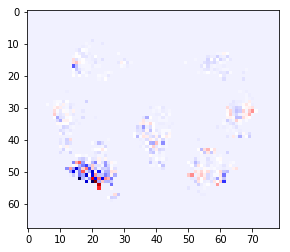

In [11]:
# Choose one person and one dimension
R_ = np.load('social_physical_brain_relevance_cross_0.npy')[8]
R_ = R_.reshape(68,95,79)

R_ = R_[:,30]

plt.imshow(R_, cmap=plt.cm.seismic, interpolation='nearest') #, interpolation='nearest'
plt.show()